# How good are LLMs at doing probabilistic inference (continuous)

The idea is that we pass a bunch of CPTs and we ask the LLM to give us the probability of a specific case.

We also ask it to estimate the mean and std.

We then compare the LLM result with that of a Bayesian network.

In [17]:
import sys
from pathlib import Path
from os import getenv

from openai import OpenAI
from scipy.stats import norm
from pgmpy.models import LinearGaussianBayesianNetwork

# Set the base path
base_path = Path("../../")  # One level up from the current working directory

# Add the src/ directory to sys.path using base_path
sys.path.append(str((base_path / "src").resolve()))

from bn_utils import draw_bayesian_network
from continuous.gaussian_inference import inference, format_continuous_query
from continuous.pgmpy_to_joint_gaussian import pgmpy_to_joint_gaussian
from yaml_utils import load_yaml
from llm_calling import run_llm_call

## Create BN with defined structure and random parameters

In [6]:
def create_cancer_model(use_random=False):
    """
    Create the Linear Gaussian Bayesian Network with either random or specific parameters.
    
    Args:
        use_random (bool): If True, use random parameters. If False, use predefined parameters.
    
    Returns:
        model: LinearGaussianBayesianNetwork with CPDs set
        cpds_dict: Dictionary mapping variable names to their CPDs
    """
    
    # Create the model structure
    model = LinearGaussianBayesianNetwork([
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Cancer", "Dyspnoea"),
    ])
    
    if use_random:
        # Use random parameters
        model.get_random_cpds(inplace=True)
        print("Created model with random parameters")
    else:
        # Use specific predefined parameters
        from pgmpy.factors.continuous import LinearGaussianCPD
        
        # P(Pollution) = N(0.305; 1.04)
        pollution_cpd = LinearGaussianCPD('Pollution', [0.305], 1.04)
        
        # P(Smoker) = N(1.446; 0.102)
        smoker_cpd = LinearGaussianCPD('Smoker', [1.446], 0.102)
        
        # P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
        cancer_cpd = LinearGaussianCPD('Cancer', [0.244, 0.678, -0.586], 0.909, 
                                      evidence=['Pollution', 'Smoker'])
        
        # P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
        xray_cpd = LinearGaussianCPD('Xray', [-0.458, -0.623], 0.135, 
                                    evidence=['Cancer'])
        
        # P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)
        dyspnoea_cpd = LinearGaussianCPD('Dyspnoea', [-0.503, 1.218], 0.271, 
                                        evidence=['Cancer'])
        
        # Add CPDs to model
        model.add_cpds(pollution_cpd, smoker_cpd, cancer_cpd, xray_cpd, dyspnoea_cpd)
        print("Created model with predefined parameters")
    
    # Verify model
    assert model.check_model(), "Model validation failed"
    
    # Create CPDs dictionary
    cpds_dict = {cpd.variable: cpd for cpd in model.get_cpds()}

    
    return model, cpds_dict

# Create model with predefined parameters
model, cpds_dict = create_cancer_model(use_random=False)

# Or create with random parameters:
# model, cpds_dict = create_cancer_model(use_random=True)

# Display model info
nodes = model.nodes()
edges = model.edges()
cpds = model.get_cpds()

cpd_strings = []
for cpd in cpds:
    cpd_strings.append(str(cpd))

cpds_as_string = "\n".join(cpd_strings)

print(f"\nNodes in the model: {nodes}")
print(f"Edges in the model: {edges}")
print(f"CPDs in the model:")
print(cpds_as_string)

Created model with predefined parameters

Nodes in the model: ['Pollution', 'Cancer', 'Smoker', 'Xray', 'Dyspnoea']
Edges in the model: [('Pollution', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea'), ('Smoker', 'Cancer')]
CPDs in the model:
P(Pollution) = N(0.305; 1.04)
P(Smoker) = N(1.446; 0.102)
P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)


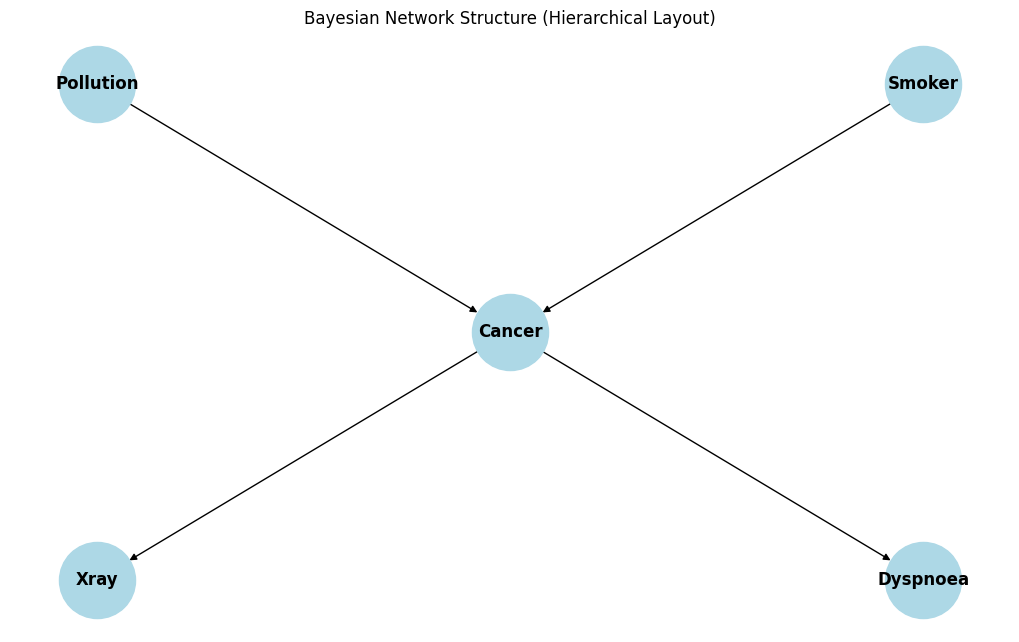

In [3]:
draw_bayesian_network(model)

## Prepare prompt

In [4]:
# Load prompt
prompt_path = base_path / "notebooks" / "continuous" / "prompts.yaml"
prompts = load_yaml(prompt_path)

In [7]:
# Example 1: Posterior estimation query
evidence = {'Dyspnoea': 0.5}
variable = 'Pollution'

query_str = format_continuous_query(variable, evidence)

prompt_str = prompts["prompt_base"].format(cpts=cpds_as_string, query=query_str)

messages = [
    {"role": "system", "content": prompts["system_prompt"]},
    {"role": "user", "content": prompt_str}
]

print("Query:", query_str)

Query: P(Pollution | Dyspnoea = 0.5)


In [ ]:
# print(prompts["system_prompt"])
# print(messages[1]["content"])

## Run exact inference

In [10]:
# Convert the Linear Gaussian BN to joint Gaussian representation
mean, cov, variable_names = pgmpy_to_joint_gaussian(model)

print("Joint Gaussian Distribution:")
print(f"Variables: {variable_names}")
print(f"Mean vector: {mean}")
print(f"Covariance matrix shape: {cov.shape}")
print()

Joint Gaussian Distribution:
Variables: ['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dyspnoea']
Mean vector: [ 0.305       1.446      -0.396566   -0.21093938 -0.98601739]
Covariance matrix shape: (5, 5)



In [ ]:
# Exact inference
# What is P(Pollution | Dyspnoea = 0.5)?
result = inference(mean, cov, variable_names, 'Pollution', evidence={'Dyspnoea': 0.5})
print("Query: P(Pollution | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print()

Query: P(Pollution | Dyspnoea = 0.5)
Mean: 0.9550
Std: 0.8312



## Initialize LLM

In [12]:
# MODEL = "gpt-4o-mini" # To test the baseline performance of LLMs
# MODEL = "deepseek/deepseek-r1" 
# MODEL = "anthropic/claude-3.7-sonnet:thinking"
# MODEL = "google/gemini-2.5-pro-preview"
MODEL = "openai/o3-mini-high"

In [13]:
# Initialize OpenAI client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY")
)

## Run LLM

In [14]:
response, messages = run_llm_call(
    openai_client=client,
    model=MODEL,
    messages=messages
)

print("LLM Response:")
print(response)

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


LLM Response:
We wish to “invert” the model so as to compute the posterior distribution of Pollution given that Dyspnoea is observed to be 0.5. In our network the chain from Pollution to Dyspnoea runs as

  Pollution → Cancer → Dyspnoea

(with Smoker also influencing Cancer, but independent of Pollution). Because all CPDs are linear‐Gaussian, the joint distribution over Pollution and Dyspnoea is bivariate Gaussian, so the answer will be

  P(Pollution | Dyspnoea = 0.5) = N(μ*, σ*²)
  with
   μ* = μₚ + (Cov(P,D)/Var(D))·(0.5 – μ_D)
   σ*² = Var(P) – (Cov(P,D)²/Var(D)).

Below we show one way to “collapse” the network into a 2‑variable model.

──────────────────────────────
Step 1. Write down the base CPDs

1. Pollution:  P(Pollution) = N(0.305; 1.04)  
           mean μₚ = 0.305, variance σₚ² = (1.04)² = 1.0816.

2. Smoker:   P(Smoker) = N(1.446; 0.102)  
           mean μ_S = 1.446, variance σ_S² = (0.102)² = 0.010404.

3. Cancer | Pollution, Smoker:  
  P(Cancer | Pollution, Smoker) =

## Example 2: Probability Calculation Query

In [15]:
# Example 2: Probability calculation for interval
evidence2 = {'Dyspnoea': 0.5}
variable2 = 'Pollution'
prob_range = (0, 1)  # P(0 < Pollution < 1 | Dyspnoea = 0.5)

query_str2 = format_continuous_query(variable2, evidence2, prob_range)

prompt_str2 = prompts["prompt_base"].format(cpts=cpds_as_string, query=query_str2)

messages2 = [
    {"role": "system", "content": prompts["system_prompt"]},
    {"role": "user", "content": prompt_str2}
]

print("Query:", query_str2)

Query: P(0 < Pollution < 1 | Dyspnoea = 0.5)


In [21]:
print(prompt_str2)

## Task

Below you will find conditional probability distributions (CPDs) and a query. Compute the exact result for the query.

**Conditional Probability Distributions (CPDs):**

P(Pollution) = N(0.305; 1.04)
P(Smoker) = N(1.446; 0.102)
P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)

## Query

P(0 < Pollution < 1 | Dyspnoea = 0.5)

## Output Format

**For posterior estimation queries (asking for posterior mean and std):**
```
Mean: <numeric_value>
Std: <numeric_value>
```

**For probability calculation queries (asking for probability of intervals/bounds):**
```
P(<condition>): <numeric_probability>
```

## Query Types Explained

### 1. Posterior Estimation
When asked for a conditional distribution like P(A | B = 1.0, C = 2.0), provide the posterior mean and standard deviation.

### 2. Probability Calculation
When asked for probability of interval

In [18]:
# What is P(0 < Pollution < 1 | Dyspnoea = 0.5)?
result = inference(mean, cov, variable_names, 'Pollution', evidence={'Dyspnoea': 0.5})

# Calculate probability manually using scipy.stats.norm
prob = norm.cdf(1, result['mean'], result['std']) - norm.cdf(0, result['mean'], result['std'])

print("Query: P(0 < Pollution < 1 | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"P(0 < Pollution < 1): {prob:.4f}")
print()

Query: P(0 < Pollution < 1 | Dyspnoea = 0.5)
Mean: 0.9550
Std: 0.8312
P(0 < Pollution < 1): 0.3963



In [19]:
response2, messages2 = run_llm_call(
    openai_client=client,
    model=MODEL,
    messages=messages2
)

print("LLM Response for probability calculation:")
print(response2)

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


LLM Response for probability calculation:
We wish to compute

  P(0 < Pollution < 1 | Dyspnoea = 0.5).

Because our network is fully linear–Gaussian, the joint distribution over Pollution (call it X) and Dyspnoea (call it D) is bivariate normal. Then the posterior (conditional) distribution X | D = d is Gaussian and once that is computed the desired probability is the probability that X lies between 0 and 1 under that normal.

Below is one way to “collapse” the full model into an (X,D) bivariate system.

──────────────────────────────
Step 1. Write down the CPDs.

• Pollution: 
  X ~ N(μ_X = 0.305, σ_X = 1.04)    → Var(X) = 1.04² = 1.0816.

• Smoker:
  S ~ N(μ_S = 1.446, σ_S = 0.102)    → Var(S) = 0.102² ≈ 0.010404.

• Cancer given Pollution and Smoker:
  Cancer = 0.678·X + (–0.586)·S + 0.244 + ε_C
   where ε_C ~ N(0, 0.909²) and 0.909² ≈ 0.826.

• Dyspnoea given Cancer:
  D = 1.218·Cancer + (–0.503) + ε_D
   where ε_D ~ N(0, 0.271²) and 0.271² ≈ 0.073441.

────────────────────────────